In [1]:
# Custom Neural Network For Digit Classification

# Imports and 
import numpy as np
import random

import pickle
import gzip

from matplotlib import pyplot as plt

class Network(object): 
    # The following class works to create a neural network that has 
    # the goal of classifying digits. It has been developed with help 
    # from http://neuralnetworksanddeeplearning.com/chap1.html as 
    # well as the following video series from 3Blue1Brown, at 
    # https://www.youtube.com/watch?v=aircAruvnKk. 

    # INITIALIZATION OF THE NETWORK CLASS (CONSTRUCTOR) 
    # ----------------------------------------------------------------------------------------------

    def __init__(self, sizes): 
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = []
        self.weights = []

        for y in sizes[1:]:
            self.biases.append(np.random.randn(y, 1))
        
        for x, y in zip(sizes[:-1], sizes[1:]):
            self.weights.append(np.random.randn(y, x))

    # ----------------------------------------------------------------------------------------------

    # Note that for the feedforward() function, a, which is the input 
    # vector modelling the input parameters of a particular data sample, 
    # has to be passed in as an (n x 1) vector, meaning it is a 2D array. 

    # FUNCTION 1: feedforward() 
    # ----------------------------------------------------------------------------------------------
    def feedforward(self, a): 
        for b, w in zip(self.biases, self.weights): 
            a = sigmoid(np.dot(w, a) + b)
        
        return a

    # ----------------------------------------------------------------------------------------------

    # Here, x is an (n x 1) vector representing the input parameters 
    # for a specific data value. This vector, as it is the input vector, 
    # is also the vector representing the activations of the first 
    # layer. 
    
    # FUNCTION 2: backpropagation()
    # ----------------------------------------------------------------------------------------------
    def backpropagation(self, x, y): 

        # These are the arrays storing the gradients to change the 
        # weights and biases by. They are very interesting and 
        # very useful. 

        gradient_weights = []
        gradient_biases = []

        # The following code works to find all the activations in the 
        # network. This allows backpropagation to function correctly 
        # later. The activations are then placed in 
        currentactivation = x
        activations = [x]
        z_values = []

        for b, w in zip(self.biases, self.weights): 

            # At this point, currentactivation is the z value for 
            # that layer. It is appended to array z_values. 
            currentactivation = np.dot(w, currentactivation) + b
            z_values.append(currentactivation)

            # Here, currentactivation then has the sigmoid function 
            # applied to it, and is the vector of activations. It 
            # is appended to the array activations. 
            currentactivation = sigmoid(currentactivation)
            activations.append(currentactivation)
        
        # Here, we calculate the error in the last layer, and use that information 
        # to calculate the needed change in weights and costs, gradient_weights 
        # and gradient_costs, to the network. 
        current_error = (activations[-1] - y) * sigmoid_derivative(z_values[-1])
        gradient_weights.insert(0, np.dot(current_error, activations[-2].transpose()))
        gradient_biases.insert(0, current_error)

        # Now, backpropagation begins and continutes until the first layer. 

        for layer in range(2, self.num_layers): 
            current_error = np.dot(np.transpose(self.weights[-layer + 1]), current_error) \
                * sigmoid_derivative(z_values[-layer])
            
            gradient_biases.insert(0, current_error)
            gradient_weights.insert(0, np.dot(current_error, 
                np.transpose(activations[-layer-1])))

        return (gradient_biases, gradient_weights)

    # ----------------------------------------------------------------------------------------------

    # FUNCTION 3: update_batch()
    # ----------------------------------------------------------------------------------------------
    def update_batch(self, batch, learning_rate): 
        # Here, we will create the combined gradient matrices. 

        gradient_biases = [np.zeros(b.shape) for b in self.biases]
        gradient_weights = [np.zeros(w.shape) for w in self.weights]

        # We iterate through every data point in the batch, and use the 
        # backpropagation method to find the gradient that the biases 
        # and weights should change by. Then, it 

        for x, y in batch: 
            delta_gradient_biases, delta_gradient_weights = self.backpropagation(x, y)

            # Iterates through the bias gradient for the current data point 
            # in the batch, and then adds it to the summmed up bias gradient 
            # array, which is gradient_biases. 

            gradient_biases = [nb+dnb for nb, dnb in zip(gradient_biases, delta_gradient_biases)]

            # Iterates through the weight gradient for the current data point 
            # in the batch, and then adds it to the summmed up weight gradient 
            # array, which is weight_biases. 

            gradient_weights = [nb+dnb for nb, dnb in zip(gradient_weights, delta_gradient_weights)]
        
        self.weights = [original_weights - (learning_rate/len(batch)) * shift_weights
            for original_weights, shift_weights in zip(self.weights, gradient_weights)]
        
        self.biases = [original_biases - (learning_rate/len(batch)) * shift_biases
            for original_biases, shift_biases in zip(self.biases, gradient_biases)]

    # ----------------------------------------------------------------------------------------------

    # FUNCTION 4: stochasticgradientdescent() 
    # ----------------------------------------------------------------------------------------------
    def stochasticgradientdescent(self, training_data, num_epochs, batch_size, learning_rate, test_data): 

        dataBeingTested = True

        if dataBeingTested: 
            # test_data = list(test_data)
            lengthTestData = len(test_data)


        for epoch in range(num_epochs): 
            i = 0
            random.shuffle(training_data)

            batches = [training_data[start: start + batch_size] 
                       for start in range(0, len(training_data), batch_size)]

            for batch in batches: 
                # print("Batch " + str(i) + " is being run.")
                self.update_batch(batch, learning_rate)
                i = i + 1
                
            
            if dataBeingTested: 
                print("Epoch {} : {} / {}".format(epoch, self.evaluate(test_data), lengthTestData))
            else: 
                print("Epoch %s completed. Let's gooooo."%(str(epoch)))

    # ----------------------------------------------------------------------------------------------
    
    # FUNCTION 5: evaluate()
    # ----------------------------------------------------------------------------------------------
    def evaluate(self, test_data): 

        num_correct = 0

        for (input, output) in test_data: 
            test_result = self.feedforward(input)

            calculated_activation = 0
            calculated_output = 0

            for x in range(len(test_result)): 
                if (test_result[x][0] > calculated_activation): 
                    calculated_output = x
                    calculated_activation = test_result[x]
            
            if (calculated_output == output): 
                num_correct = num_correct + 1
        
        return num_correct

    # ----------------------------------------------------------------------------------------------

    # FUNCTION 6: test_example()
    # ----------------------------------------------------------------------------------------------
    def test_example(self, test): 
        test_result = self.feedforward(test[0])

        calculated_activation = 0
        calculated_output = 0

        for x in range(len(test_result)): 
            if (test_result[x][0] > calculated_activation): 
                calculated_output = x
                calculated_activation = test_result[x]
        
        print("Neural Network Prediciton: " + str(calculated_output))
        print("Actual Written Number: " + str(test[1]) + "\n")

        if (calculated_output == test[1]): 
            return 1
        else: 
            return 0

    # ----------------------------------------------------------------------------------------------
    
    # FUNCTION 7: print2DArray() 
    # ----------------------------------------------------------------------------------------------
    def print2DArray(self, array):
        numRows = len(array)
        numColumns = len(array[0])

        for x in range(numRows):
            print("[")
            for y in range(numColumns):
                print(str(array[x][y]) + ", ")
            print("]\n")

    # ----------------------------------------------------------------------------------------------

    # FUNCTION 8: print1DArray()
    # ----------------------------------------------------------------------------------------------
    def print1DArray(self, array):
        numElements = len(array)
        print("[")
        for x in range(numElements):
            print(str(array[x]) + ", ")
        print("]\n")

    # ----------------------------------------------------------------------------------------------
    
# FUNCTION 9: sigmoid(z)
# --------------------------------------------------------------------------------------------------
def sigmoid(z): 
    return 1.0/(1.0 + np.exp(-z))
# --------------------------------------------------------------------------------------------------

# FUNCTION 10: sigmoid_derivative(z)
# --------------------------------------------------------------------------------------------------
def sigmoid_derivative(z): 
    return np.exp(-z) / (1 + 2*np.exp(-z) + np.exp(-2 * z))

# --------------------------------------------------------------------------------------------------

# FUNCTION 11: create_result_vector() 
# --------------------------------------------------------------------------------------------------
def create_result_vector(position): 
    vector = np.zeros((10, 1))
    vector[position] = 1.0
    return vector

# --------------------------------------------------------------------------------------------------

# MAIN CODE 
# --------------------------------------------------------------------------------------------------

f = gzip.open('./mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding = "latin1")
f.close()

training_inputs = [np.reshape(x, (784, 1)) for x in training_data[0]]
training_results = [create_result_vector(y) for y in training_data[1]]
training_data = zip(training_inputs, training_results)
training_data = list(training_data)

validation_inputs = [np.reshape(x, (784, 1)) for x in validation_data[0]]
validation_data = zip(validation_inputs, validation_data[1])

test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
test_data = zip(test_inputs, test_data[1])
test_data = list(test_data)

validation_data = list(validation_data)

network = Network([784, 30, 10])
print("Training the Dataset Now")
print("Epoch -1: {} / {}".format(str(network.evaluate(test_data)), len(test_data)))
network.stochasticgradientdescent(training_data, 10, 30, 3.0, test_data = test_data)

Training the Dataset Now
Epoch -1: 1011 / 10000
Epoch 0 : 8735 / 10000
Epoch 1 : 9041 / 10000
Epoch 2 : 9141 / 10000
Epoch 3 : 9210 / 10000
Epoch 4 : 9273 / 10000
Epoch 5 : 9288 / 10000
Epoch 6 : 9326 / 10000
Epoch 7 : 9331 / 10000
Epoch 8 : 9344 / 10000
Epoch 9 : 9362 / 10000


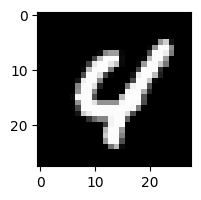

Neural Network Prediciton: 4
Actual Written Number: 4



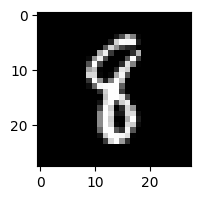

Neural Network Prediciton: 8
Actual Written Number: 8



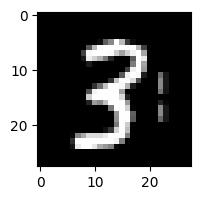

Neural Network Prediciton: 3
Actual Written Number: 3



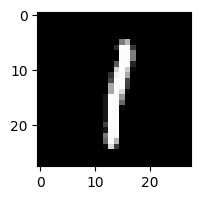

Neural Network Prediciton: 1
Actual Written Number: 1



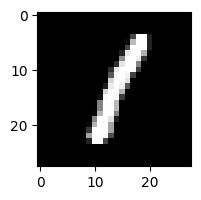

Neural Network Prediciton: 1
Actual Written Number: 1



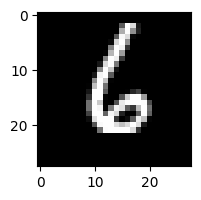

Neural Network Prediciton: 6
Actual Written Number: 6



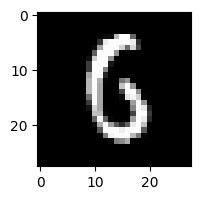

Neural Network Prediciton: 6
Actual Written Number: 6



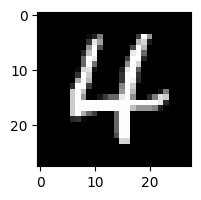

Neural Network Prediciton: 4
Actual Written Number: 4



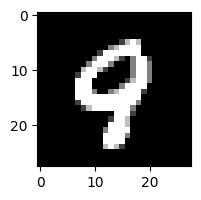

Neural Network Prediciton: 9
Actual Written Number: 9



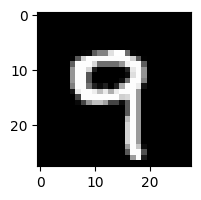

Neural Network Prediciton: 9
Actual Written Number: 9



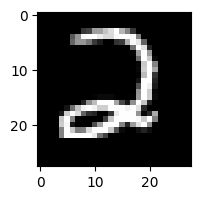

Neural Network Prediciton: 2
Actual Written Number: 2



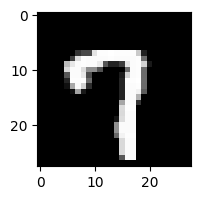

Neural Network Prediciton: 7
Actual Written Number: 7



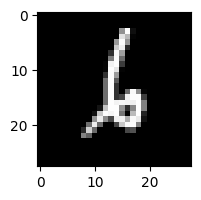

Neural Network Prediciton: 2
Actual Written Number: 6



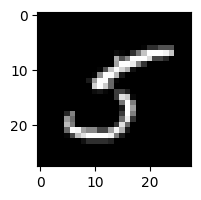

Neural Network Prediciton: 5
Actual Written Number: 5



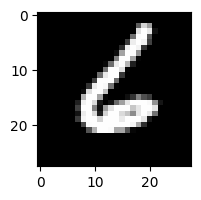

Neural Network Prediciton: 6
Actual Written Number: 6



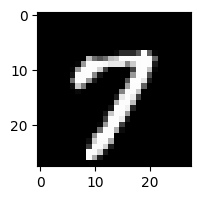

Neural Network Prediciton: 7
Actual Written Number: 7



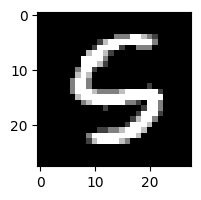

Neural Network Prediciton: 5
Actual Written Number: 5



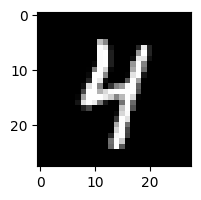

Neural Network Prediciton: 4
Actual Written Number: 4



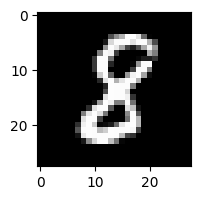

Neural Network Prediciton: 8
Actual Written Number: 8



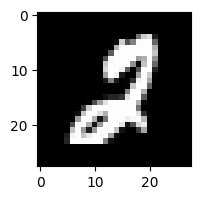

Neural Network Prediciton: 2
Actual Written Number: 2



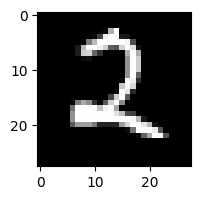

Neural Network Prediciton: 2
Actual Written Number: 2



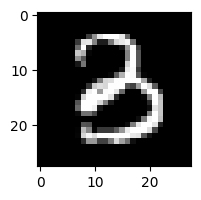

Neural Network Prediciton: 3
Actual Written Number: 3



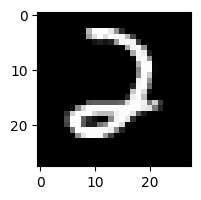

Neural Network Prediciton: 2
Actual Written Number: 2



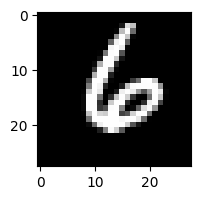

Neural Network Prediciton: 6
Actual Written Number: 6



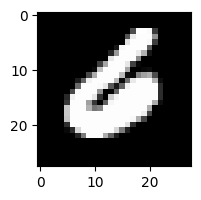

Neural Network Prediciton: 6
Actual Written Number: 6

Validation Data Test Overview
There were 24 correct predictions.
There were 1 incorrect predictions.


In [7]:
random.shuffle(validation_data)
sample_size = 25
num_correct = 0

for x in range(sample_size): 
    image = np.array(validation_data[x][0], dtype = 'float') 
    image = image.reshape((28, 28))
    plt.figure(figsize = (2, 2))
    plt.imshow(image, cmap = "gray")
    plt.show()

    if (network.test_example(validation_data[x]) == 1): 
        num_correct = num_correct + 1

print("Validation Data Test Overview")
print("There were " + str(num_correct) + " correct predictions.")
print("There were " + str(sample_size - num_correct) + " incorrect predictions.")